In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

C:\Users\Janus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras import backend as K
import matplotlib.pyplot as plt
import skimage
from skimage.metrics import structural_similarity as ssim
import time
import cv2
import scipy.stats as stats
import seaborn as sns
import scipy.io

In [3]:
msel = tf.keras.losses.MeanSquaredError()

def log10_(x):
  numerator = K.log(x)
  denominator = K.log(K.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def PSNR_train(y_true, y_pred):
  max_pixel = 1
  return 10.0 * log10_(  (max_pixel) / msel(y_true,y_pred)   )

def PSNR(y_true, y_pred):
  max_pixel = y_true.max()
  return 10.0 * log10_(  (max_pixel) / msel(y_true,y_pred)   )

def mse(vref, vcmp):

    if np.iscomplexobj(vref) or np.iscomplexobj(vcmp):
        dtype = np.complex128
    else:
        dtype = np.float64
    r = np.asarray(vref, dtype=dtype).ravel()
    c = np.asarray(vcmp, dtype=dtype).ravel()
    return np.mean(np.abs(r - c)**2)

def snr(vref, vcmp):

    dv = np.var(vref)
    with np.errstate(divide='ignore'):
        rt = dv / mse(vref, vcmp)
    return 10.0 * np.log10(rt)

def ssim_train(y_true, y_pred):
  max_val = 1
  return tf.image.ssim(y_true, y_pred, max_val)

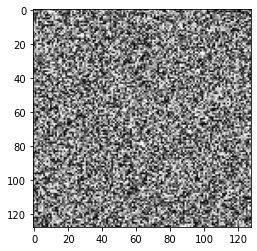

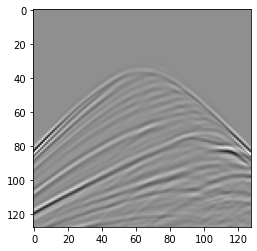

In [4]:
m2 = 128
n2 = 128
l1 = 16

#----------------------------------------------------------------------

x = np.load('data/data_synthetic_land_16shots.npy')

#----------------------------------------------------------------------

t = x.shape
m1 = t[0]
n1 = t[1]
l1 = t[2]

shots_delete = [3,5,7,10,12]
shots_p = [0,1,2,4,6,8,9,11,13,14,15]
num_delete_shots = 5

y_train = np.ndarray((1,m2,n2,l1-num_delete_shots,1),dtype="float32")
for i in range(l1-num_delete_shots):
    y_train[0,:,:,i,0] = x[:,:,shots_p[i]]

np.random.seed(0)
z_iter = np.random.rand(1,m2,n2,l1,1)
z_iter = np.float32(z_iter)

plt.imshow(z_iter[0,:,:,0,0],cmap='gray')
plt.show()

plt.imshow(y_train[0,:,:,10,0],cmap='gray')
plt.show()

z_iter = tf.convert_to_tensor(z_iter)

In [5]:
def model_unet(pretrained_weights=None,input_size=(m2,l1,1),FLAGS=None):
    inputs = Input(input_size)
    kernel=3
    conv1 = Conv2D(16, kernel, padding="same")(inputs)
    bn1 = BatchNormalization()(conv1)
    relu1 = LeakyReLU()(bn1)
    conv1 = Conv2D(16, kernel, padding="same")(relu1)
    bn1 = BatchNormalization()(conv1)
    relu1_sc = LeakyReLU()(bn1)
    conv1 = Conv2D(16, kernel, strides=(2, 2), padding="same")(relu1_sc)
    bn1 = BatchNormalization()(conv1)
    relu1 = LeakyReLU()(bn1)

    conv2 = Conv2D(32, kernel, padding="same")(relu1)
    bn2 = BatchNormalization()(conv2)
    relu2 = LeakyReLU()(bn2)
    conv2 = Conv2D(32, kernel, padding="same")(relu2)
    bn2 = BatchNormalization()(conv2)
    relu2_sc = LeakyReLU()(bn2)
    conv2 = Conv2D(32, kernel, strides=(2, 2), padding="same")(relu2_sc)
    bn2 = BatchNormalization()(conv2)
    relu2 = LeakyReLU()(bn2)

    conv3 = Conv2D(64, kernel, padding="same")(relu2)
    bn3 = BatchNormalization()(conv3)
    relu3 = LeakyReLU()(bn3)
    conv3 = Conv2D(64, kernel, padding="same")(relu3)
    bn3 = BatchNormalization()(conv3)
    relu3_sc = LeakyReLU()(bn3)
    conv3 = Conv2D(64, kernel, strides=(2, 2), padding="same")(relu3_sc)
    bn3 = BatchNormalization()(conv3)
    relu3 = LeakyReLU()(bn3)

    conv4 = Conv2D(128, kernel, padding="same")(relu3)
    bn4 = BatchNormalization()(conv4)
    relu4 = LeakyReLU()(bn4)
    conv4 = Conv2D(128, kernel, padding="same")(relu4)
    bn4 = BatchNormalization()(conv4)
    relu4_sc = LeakyReLU()(bn4)
    conv4 = Conv2D(128, kernel, strides=(2, 2), padding="same")(relu4_sc)
    bn4 = BatchNormalization()(conv4)
    relu4 = LeakyReLU()(bn4)

    #middle
    conv5 = Conv2D(128, kernel, padding="same")(relu4)
    bn5 = BatchNormalization()(conv5)
    relu5 = LeakyReLU()(bn5)
    conv5 = Conv2D(128, kernel, padding="same")(relu5)
    bn5 = BatchNormalization()(conv5)
    relu5 = LeakyReLU()(bn5)
    up5 = UpSampling2D((2, 2), interpolation='bilinear')(relu5)

    conv6 = Conv2D(128, kernel,  padding="same")(up5)
    bn6 = BatchNormalization()(conv6)
    relu6 = LeakyReLU()(bn6)
    sc6 = Add()([relu6, relu4_sc])
    conv6 = Conv2D(128, kernel,  padding="same")(sc6)
    bn6 = BatchNormalization()(conv6)
    relu6 = LeakyReLU()(bn6)
    conv6 = Conv2D(128, kernel,  padding="same")(relu6)
    bn6 = BatchNormalization()(conv6)
    relu6 = LeakyReLU()(bn6)
    up6 = UpSampling2D((2, 2), interpolation='bilinear')(relu6)

    conv7 = Conv2D(64, kernel,  padding="same")(up6)
    bn7 = BatchNormalization()(conv7)
    relu7 = LeakyReLU()(bn7)
    sc7 = Add()([relu7, relu3_sc])
    conv7 = Conv2D(64, kernel,  padding="same")(sc7)
    bn7 = BatchNormalization()(conv7)
    relu7 = LeakyReLU()(bn7)
    conv7 = Conv2D(64, kernel,  padding="same")(relu7)
    bn7 = BatchNormalization()(conv7)
    relu7 = LeakyReLU()(bn7)
    up7 = UpSampling2D((2, 2), interpolation='bilinear')(relu7)

    conv8 = Conv2D(32, kernel,  padding="same")(up7)
    bn8 = BatchNormalization()(conv8)
    relu8 = LeakyReLU()(bn8)
    sc8 = Add()([relu8, relu2_sc])
    conv8 = Conv2D(32, kernel,  padding="same")(sc8)
    bn8 = BatchNormalization()(conv8)
    relu8 = LeakyReLU()(bn8)
    conv8 = Conv2D(32, kernel,  padding="same")(relu8)
    bn8 = BatchNormalization()(conv8)
    relu8 = LeakyReLU()(bn8)
    up8 = UpSampling2D((2, 2), interpolation='bilinear')(relu8)

    conv9 = Conv2D(16, kernel,  padding="same")(up8)
    bn9 = BatchNormalization()(conv9)
    relu9 = LeakyReLU()(bn9)
    sc9 = Add()([relu9, relu1_sc])
    conv9 = Conv2D(16, kernel,  padding="same")(sc9)
    bn9 = BatchNormalization()(conv9)
    relu9 = LeakyReLU()(bn9)
    conv9 = Conv2D(16, kernel,  padding="same")(relu9)
    bn9 = BatchNormalization()(conv9)
    relu9 = LeakyReLU()(bn9)
    conv9 = Conv2D(1, kernel,  padding="same")(relu9)
    bn9 = BatchNormalization()(conv9)
    relu9 = LeakyReLU()(bn9)

    output = Lambda(lambda x: tf.gather(x[0], x[1], axis=2))([relu9,shots_p])

    model = Model(inputs, output)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

unet = model_unet(input_size=(m2,l1,1))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 16, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 16, 16)          160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 16, 16)          64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 16, 16)          0         ['batch_normalization[0][0

                                                                                                  
 conv2d_10 (Conv2D)          (None, 16, 2, 128)           147584    ['leaky_re_lu_9[0][0]']       
                                                                                                  
 batch_normalization_10 (Ba  (None, 16, 2, 128)           512       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 2, 128)           0         ['batch_normalization_10[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 8, 1, 128)            147584    ['leaky_re_lu_10[0][0]']      
          

                                                                    ']                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 32, 4, 64)            36928     ['leaky_re_lu_18[0][0]']      
                                                                                                  
 batch_normalization_19 (Ba  (None, 32, 4, 64)            256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 4, 64)            0         ['batch_normalization_19[0][0]
                                                                    ']                            
                                                                                                  
 up_sampli

In [6]:
X_reconstructed_total = np.ndarray((m2,n2,l1),dtype="float32")

for i in range(n2):
  print('Iter: ',i)

  y_iter = y_train[:,:,i,:,:]
  z_i = z_iter[:,:,i,:,:]

  unet = model_unet(input_size=(m2,l1,1))

  initial_learning_rate = 1e-3
  opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

  unet.compile(optimizer=opt,loss=msel,metrics=[PSNR_train,ssim_train,msel])
  history = unet.fit(z_i,y_iter,epochs=1000,batch_size=1, verbose='True')

  output = unet.layers[-2].output
  unet_pred = Model(inputs = unet.input, outputs = output)

  predict = unet_pred.predict(z_i)
  X_reconstructed_total[:,i,:] = np.array(tf.squeeze(predict))

Iter:  0
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 

Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/

Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/

Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/

Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/

Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/

Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/

Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/

Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/

Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 292ms/step
Iter:  5
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000


Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/

Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 289ms/step
Iter:  6
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000

Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/

Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111

Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/

Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/

Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/

Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/

Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/

Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/

Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/

Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/

Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 288ms/step
Iter:  12
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000


Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/

Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Ep

Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/

Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/

Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/

Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/

Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/

Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/

Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/

Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/

Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 

Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/

Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/

Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/

Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/

Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/

Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/

Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/

Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/

Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 286ms/step
Iter:  23
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000


Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/

Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Ep

Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/

Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/

Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/

Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/

Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/

Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/

Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/

Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/

Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 292ms/step
Iter:  29
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 

Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/

Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/

Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/

Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/

Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/

Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/

Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/

Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/

Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/

Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/

Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 

Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/

Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/

Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/

Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/

Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/

Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/

Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/

Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/

Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 294ms/step
Iter:  40
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 

Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/

Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/

Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/

Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/

Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/

Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/

Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/

Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/

Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/

Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/

Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 291ms/step
Iter:  46
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000

Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/

Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epo

Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/

Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/

Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/

Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/

Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/

Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/

Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/

Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/

Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 

Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/

Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/

Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/

Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/

Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/

Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/

Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/

Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/

Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 292ms/step
Iter:  57
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000

Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/

Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epo

Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/

Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/

Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/

Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/

Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/

Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/

Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/

Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/

Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 295ms/step
Iter:  63
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch

Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/

Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/10

Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/

Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/

Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/

Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/

Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/

Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/

Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [===================

Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/

Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoc

Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/

Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/

Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/

Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/

Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/

Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/

Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/

Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/

Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 294ms/step
Iter:  74
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoc

Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/

Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/100

Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/

Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/

Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/

Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/

Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/

Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/

Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/

Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/

1/1 [==============================] - 0s 293ms/step
Iter:  80
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68

Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/

Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/

Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/

Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/

Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/

Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/

Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/

Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/

Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 295ms/step
Iter:  85
Epoch 

Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/

Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
E

Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/

Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/

Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/

Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/

Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/

Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/

Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/

Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/

Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 296ms/step
Iter:  91
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 3

Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/

Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139

Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/

Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/

Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/

Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/

Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/

Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/

Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/

Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/

Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/100

Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/

Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/

Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/

Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/

Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/

Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/

Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/

Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/

Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 294ms/step
Iter:  102
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoc

Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/

Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111

Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/

Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/

Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/

Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/

Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/

Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/

Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/

Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/

Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 299ms/step
Iter:  108
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000

Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/

Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Ep

Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/

Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/

Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/

Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/

Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/

Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/

Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/

Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/

Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 

Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/

Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/

Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/

Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/

Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/

Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/

Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/1000
Epoch 859/1000
Epoch 860/1000
Epoch 861/1000
Epoch 862/1000
Epoch 863/1000
Epoch 864/1000
Epoch 865/1000
Epoch 866/1000
Epoch 867/1000
Epoch 868/1000
Epoch 869/1000
Epoch 870/1000
Epoch 871/1000
Epoch 872/1000
Epoch 873/1000
Epoch 874/1000
Epoch 875/1000
Epoch 876/1000
Epoch 877/1000
Epoch 878/1000
Epoch 879/1000
Epoch 880/1000
Epoch 881/1000
Epoch 882/1000
Epoch 883/1000
Epoch 884/1000
Epoch 885/1000
Epoch 886/1000
Epoch 887/1000
Epoch 888/1000
Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/

Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000
Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/

Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/1000
Epoch 956/1000
Epoch 957/1000
Epoch 958/1000
Epoch 959/1000
Epoch 960/1000
Epoch 961/1000
Epoch 962/1000
Epoch 963/1000
Epoch 964/1000
Epoch 965/1000
Epoch 966/1000
Epoch 967/1000
Epoch 968/1000
Epoch 969/1000
Epoch 970/1000
Epoch 971/1000
Epoch 972/1000
Epoch 973/1000
Epoch 974/1000
Epoch 975/1000
Epoch 976/1000
Epoch 977/1000
Epoch 978/1000
Epoch 979/1000
Epoch 980/1000
Epoch 981/1000
Epoch 982/1000
Epoch 983/1000
Epoch 984/1000
Epoch 985/1000
Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 300ms/step
Iter:  119
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000

Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/1000
Epoch 506/1000
Epoch 507/1000
Epoch 508/1000
Epoch 509/1000
Epoch 510/1000
Epoch 511/1000
Epoch 512/1000
Epoch 513/1000
Epoch 514/1000
Epoch 515/1000
Epoch 516/1000
Epoch 517/1000
Epoch 518/1000
Epoch 519/1000
Epoch 520/1000
Epoch 521/1000
Epoch 522/1000
Epoch 523/1000
Epoch 524/1000
Epoch 525/1000
Epoch 526/1000
Epoch 527/1000
Epoch 528/1000
Epoch 529/1000
Epoch 530/1000
Epoch 531/1000
Epoch 532/1000
Epoch 533/1000
Epoch 534/1000
Epoch 535/1000
Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/

Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000
Epoch 79/1000
Epoch 80/1000
Epoch 81/1000
Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Ep

Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/1000
Epoch 622/1000
Epoch 623/1000
Epoch 624/1000
Epoch 625/1000
Epoch 626/1000
Epoch 627/1000
Epoch 628/1000
Epoch 629/1000
Epoch 630/1000
Epoch 631/1000
Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/

Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/

Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/1000
Epoch 699/1000
Epoch 700/1000
Epoch 701/1000
Epoch 702/1000
Epoch 703/1000
Epoch 704/1000
Epoch 705/1000
Epoch 706/1000
Epoch 707/1000
Epoch 708/1000
Epoch 709/1000
Epoch 710/1000
Epoch 711/1000
Epoch 712/1000
Epoch 713/1000
Epoch 714/1000
Epoch 715/1000
Epoch 716/1000
Epoch 717/1000
Epoch 718/1000
Epoch 719/1000
Epoch 720/1000
Epoch 721/1000
Epoch 722/1000
Epoch 723/1000
Epoch 724/1000
Epoch 725/1000
Epoch 726/1000
Epoch 727/1000
Epoch 728/1000
Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/

Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000
Epoch 272/1000
Epoch 273/1000
Epoch 274/1000
Epoch 275/1000
Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000
Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/

Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/1000
Epoch 796/1000
Epoch 797/1000
Epoch 798/1000
Epoch 799/1000
Epoch 800/1000
Epoch 801/1000
Epoch 802/1000
Epoch 803/1000
Epoch 804/1000
Epoch 805/1000
Epoch 806/1000
Epoch 807/1000
Epoch 808/1000
Epoch 809/1000
Epoch 810/1000
Epoch 811/1000
Epoch 812/1000
Epoch 813/1000
Epoch 814/1000
Epoch 815/1000
Epoch 816/1000
Epoch 817/1000
Epoch 818/1000
Epoch 819/1000
Epoch 820/1000
Epoch 821/1000
Epoch 822/1000
Epoch 823/1000
Epoch 824/1000
Epoch 825/1000
Epoch 826/1000
Epoch 827/1000
Epoch 828/1000
Epoch 829/1000
Epoch 830/1000
Epoch 831/1000
Epoch 832/1000
Epoch 833/1000
Epoch 834/1000
Epoch 835/1000
Epoch 836/1000
Epoch 837/1000
Epoch 838/1000
Epoch 839/1000
Epoch 840/1000
Epoch 841/1000
Epoch 842/1000
Epoch 843/1000
Epoch 844/1000
Epoch 845/1000
Epoch 846/1000
Epoch 847/1000
Epoch 848/1000
Epoch 849/1000
Epoch 850/1000
Epoch 851/1000
Epoch 852/1000
Epoch 853/1000
Epoch 854/1000
Epoch 855/1000
Epoch 856/1000
Epoch 857/1000
Epoch 858/

Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/1000
Epoch 363/1000
Epoch 364/1000
Epoch 365/1000
Epoch 366/1000
Epoch 367/1000
Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000
Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/

Epoch 889/1000
Epoch 890/1000
Epoch 891/1000
Epoch 892/1000
Epoch 893/1000
Epoch 894/1000
Epoch 895/1000
Epoch 896/1000
Epoch 897/1000
Epoch 898/1000
Epoch 899/1000
Epoch 900/1000
Epoch 901/1000
Epoch 902/1000
Epoch 903/1000
Epoch 904/1000
Epoch 905/1000
Epoch 906/1000
Epoch 907/1000
Epoch 908/1000
Epoch 909/1000
Epoch 910/1000
Epoch 911/1000
Epoch 912/1000
Epoch 913/1000
Epoch 914/1000
Epoch 915/1000
Epoch 916/1000
Epoch 917/1000
Epoch 918/1000
Epoch 919/1000
Epoch 920/1000
Epoch 921/1000
Epoch 922/1000
Epoch 923/1000
Epoch 924/1000
Epoch 925/1000
Epoch 926/1000
Epoch 927/1000
Epoch 928/1000
Epoch 929/1000
Epoch 930/1000
Epoch 931/1000
Epoch 932/1000
Epoch 933/1000
Epoch 934/1000
Epoch 935/1000
Epoch 936/1000
Epoch 937/1000
Epoch 938/1000
Epoch 939/1000
Epoch 940/1000
Epoch 941/1000
Epoch 942/1000
Epoch 943/1000
Epoch 944/1000
Epoch 945/1000
Epoch 946/1000
Epoch 947/1000
Epoch 948/1000
Epoch 949/1000
Epoch 950/1000
Epoch 951/1000
Epoch 952/1000
Epoch 953/1000
Epoch 954/1000
Epoch 955/

Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/1000
Epoch 482/1000
Epoch 483/1000
Epoch 484/1000
Epoch 485/1000
Epoch 486/1000
Epoch 487/1000
Epoch 488/1000
Epoch 489/1000
Epoch 490/1000
Epoch 491/1000
Epoch 492/1000
Epoch 493/1000
Epoch 494/1000
Epoch 495/1000
Epoch 496/1000
Epoch 497/1000
Epoch 498/1000
Epoch 499/1000
Epoch 500/1000
Epoch 501/1000
Epoch 502/1000
Epoch 503/1000
Epoch 504/1000
Epoch 505/

Epoch 986/1000
Epoch 987/1000
Epoch 988/1000
Epoch 989/1000
Epoch 990/1000
Epoch 991/1000
Epoch 992/1000
Epoch 993/1000
Epoch 994/1000
Epoch 995/1000
Epoch 996/1000
Epoch 997/1000
Epoch 998/1000
Epoch 999/1000
Epoch 1000/1000
1/1 [==============================] - 0s 299ms/step
Iter:  125
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch

Epoch 536/1000
Epoch 537/1000
Epoch 538/1000
Epoch 539/1000
Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/

Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000
Epoch 119/1000
Epoch 120/1000
Epoch 121/1000
Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1

Epoch 632/1000
Epoch 633/1000
Epoch 634/1000
Epoch 635/1000
Epoch 636/1000
Epoch 637/1000
Epoch 638/1000
Epoch 639/1000
Epoch 640/1000
Epoch 641/1000
Epoch 642/1000
Epoch 643/1000
Epoch 644/1000
Epoch 645/1000
Epoch 646/1000
Epoch 647/1000
Epoch 648/1000
Epoch 649/1000
Epoch 650/1000
Epoch 651/1000
Epoch 652/1000
Epoch 653/1000
Epoch 654/1000
Epoch 655/1000
Epoch 656/1000
Epoch 657/1000
Epoch 658/1000
Epoch 659/1000
Epoch 660/1000
Epoch 661/1000
Epoch 662/1000
Epoch 663/1000
Epoch 664/1000
Epoch 665/1000
Epoch 666/1000
Epoch 667/1000
Epoch 668/1000
Epoch 669/1000
Epoch 670/1000
Epoch 671/1000
Epoch 672/1000
Epoch 673/1000
Epoch 674/1000
Epoch 675/1000
Epoch 676/1000
Epoch 677/1000
Epoch 678/1000
Epoch 679/1000
Epoch 680/1000
Epoch 681/1000
Epoch 682/1000
Epoch 683/1000
Epoch 684/1000
Epoch 685/1000
Epoch 686/1000
Epoch 687/1000
Epoch 688/1000
Epoch 689/1000
Epoch 690/1000
Epoch 691/1000
Epoch 692/1000
Epoch 693/1000
Epoch 694/1000
Epoch 695/1000
Epoch 696/1000
Epoch 697/1000
Epoch 698/

Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000
Epoch 188/1000
Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000
Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000
Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000
Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/

Epoch 729/1000
Epoch 730/1000
Epoch 731/1000
Epoch 732/1000
Epoch 733/1000
Epoch 734/1000
Epoch 735/1000
Epoch 736/1000
Epoch 737/1000
Epoch 738/1000
Epoch 739/1000
Epoch 740/1000
Epoch 741/1000
Epoch 742/1000
Epoch 743/1000
Epoch 744/1000
Epoch 745/1000
Epoch 746/1000
Epoch 747/1000
Epoch 748/1000
Epoch 749/1000
Epoch 750/1000
Epoch 751/1000
Epoch 752/1000
Epoch 753/1000
Epoch 754/1000
Epoch 755/1000
Epoch 756/1000
Epoch 757/1000
Epoch 758/1000
Epoch 759/1000
Epoch 760/1000
Epoch 761/1000
Epoch 762/1000
Epoch 763/1000
Epoch 764/1000
Epoch 765/1000
Epoch 766/1000
Epoch 767/1000
Epoch 768/1000
Epoch 769/1000
Epoch 770/1000
Epoch 771/1000
Epoch 772/1000
Epoch 773/1000
Epoch 774/1000
Epoch 775/1000
Epoch 776/1000
Epoch 777/1000
Epoch 778/1000
Epoch 779/1000
Epoch 780/1000
Epoch 781/1000
Epoch 782/1000
Epoch 783/1000
Epoch 784/1000
Epoch 785/1000
Epoch 786/1000
Epoch 787/1000
Epoch 788/1000
Epoch 789/1000
Epoch 790/1000
Epoch 791/1000
Epoch 792/1000
Epoch 793/1000
Epoch 794/1000
Epoch 795/

Shot -> 3


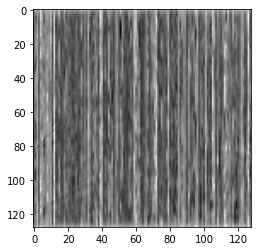

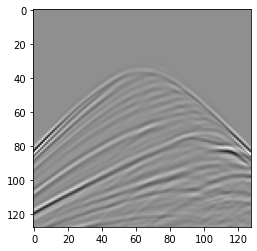

     MSE 1.309553152729269
     PSNR -1.17123
     SNR -25.56076
     SSIM -0.05374
Shot -> 5


C:\Users\Janus\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


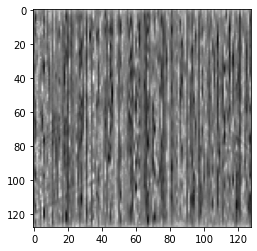

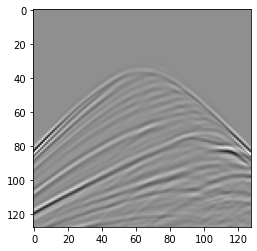

     MSE 0.6970832293407908
     PSNR 1.56715
     SNR -22.82237
     SSIM -0.02673
Shot -> 7


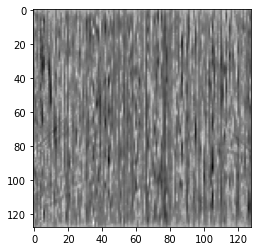

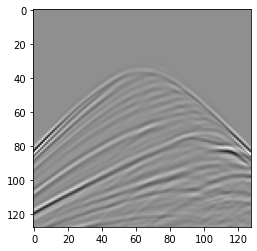

     MSE 0.4338603318093156
     PSNR 3.6265
     SNR -20.76303
     SSIM -0.00716
Shot -> 10


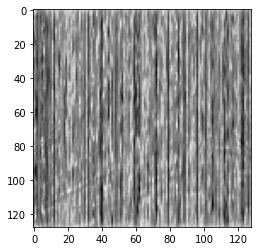

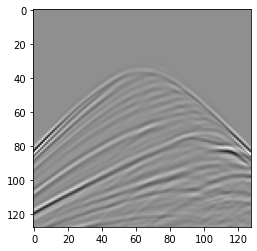

     MSE 0.4985896204787841
     PSNR 3.02257
     SNR -21.36696
     SSIM -0.01196
Shot -> 12


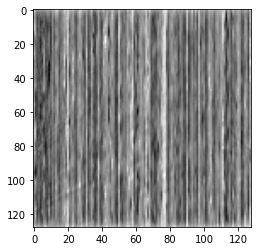

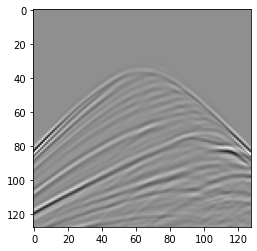

     MSE 1.0827279470939994
     PSNR -0.34519
     SNR -24.73472
     SSIM -0.05121


In [7]:
for i in range(num_delete_shots):
    print('Shot ->', shots_delete[i])
    plt.imshow(X_reconstructed_total[:,:,shots_delete[i]],cmap='gray')
    plt.show()
    plt.imshow(x[:,:,shots_delete[i]],cmap='gray')
    plt.show()
    print('     MSE', mse(x[:,:,shots_delete[i]], X_reconstructed_total[:,:,shots_delete[i]]))
    print('     PSNR', np.round(PSNR(x[:,:,shots_delete[i]], X_reconstructed_total[:,:,shots_delete[i]]).numpy(),5))
    print('     SNR', np.round(snr(x[:,:,shots_delete[i]], X_reconstructed_total[:,:,shots_delete[i]]),5))
    print('     SSIM', np.round(ssim(x[:,:,shots_delete[i]],  X_reconstructed_total[:,:,shots_delete[i]]),5))

In [ ]:
np.save('x_reconstructed_land_dsp.npy',X_reconstructed_total)